In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json


from magrec.misc.plot import plot_n_components
from magrec.misc.data import Data
from magrec import __datapath__

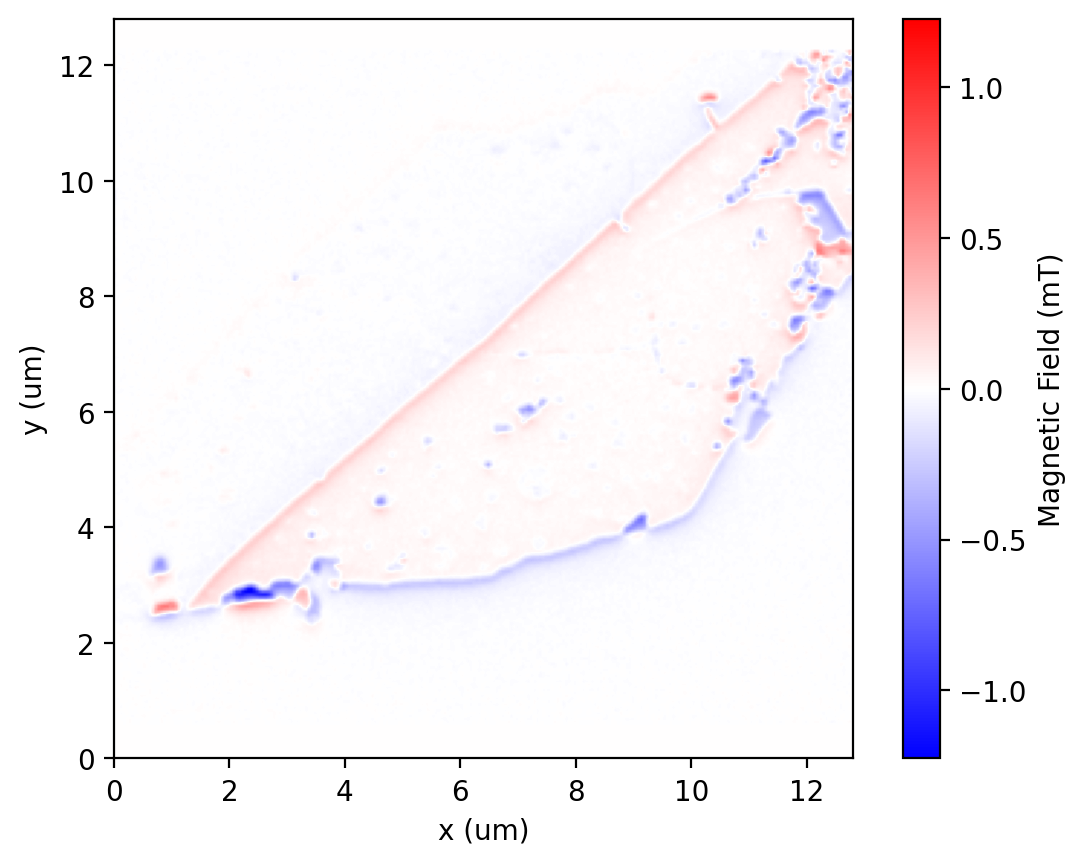

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

sensor_theta = 56
sensor_phi = 191

height = 0.035


dataset = Data()
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.add_hanning_filter(0.05)
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()

dataset.plot_target()

In [5]:
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
3,crop_data,False,crop_data,crop the data with the given region of interest,"roi = [0,256,0,256,]"
4,pad_data,True,crop_data,Padded the data to a square image with dimensi...,None


# Defining a wieght mask for fitting

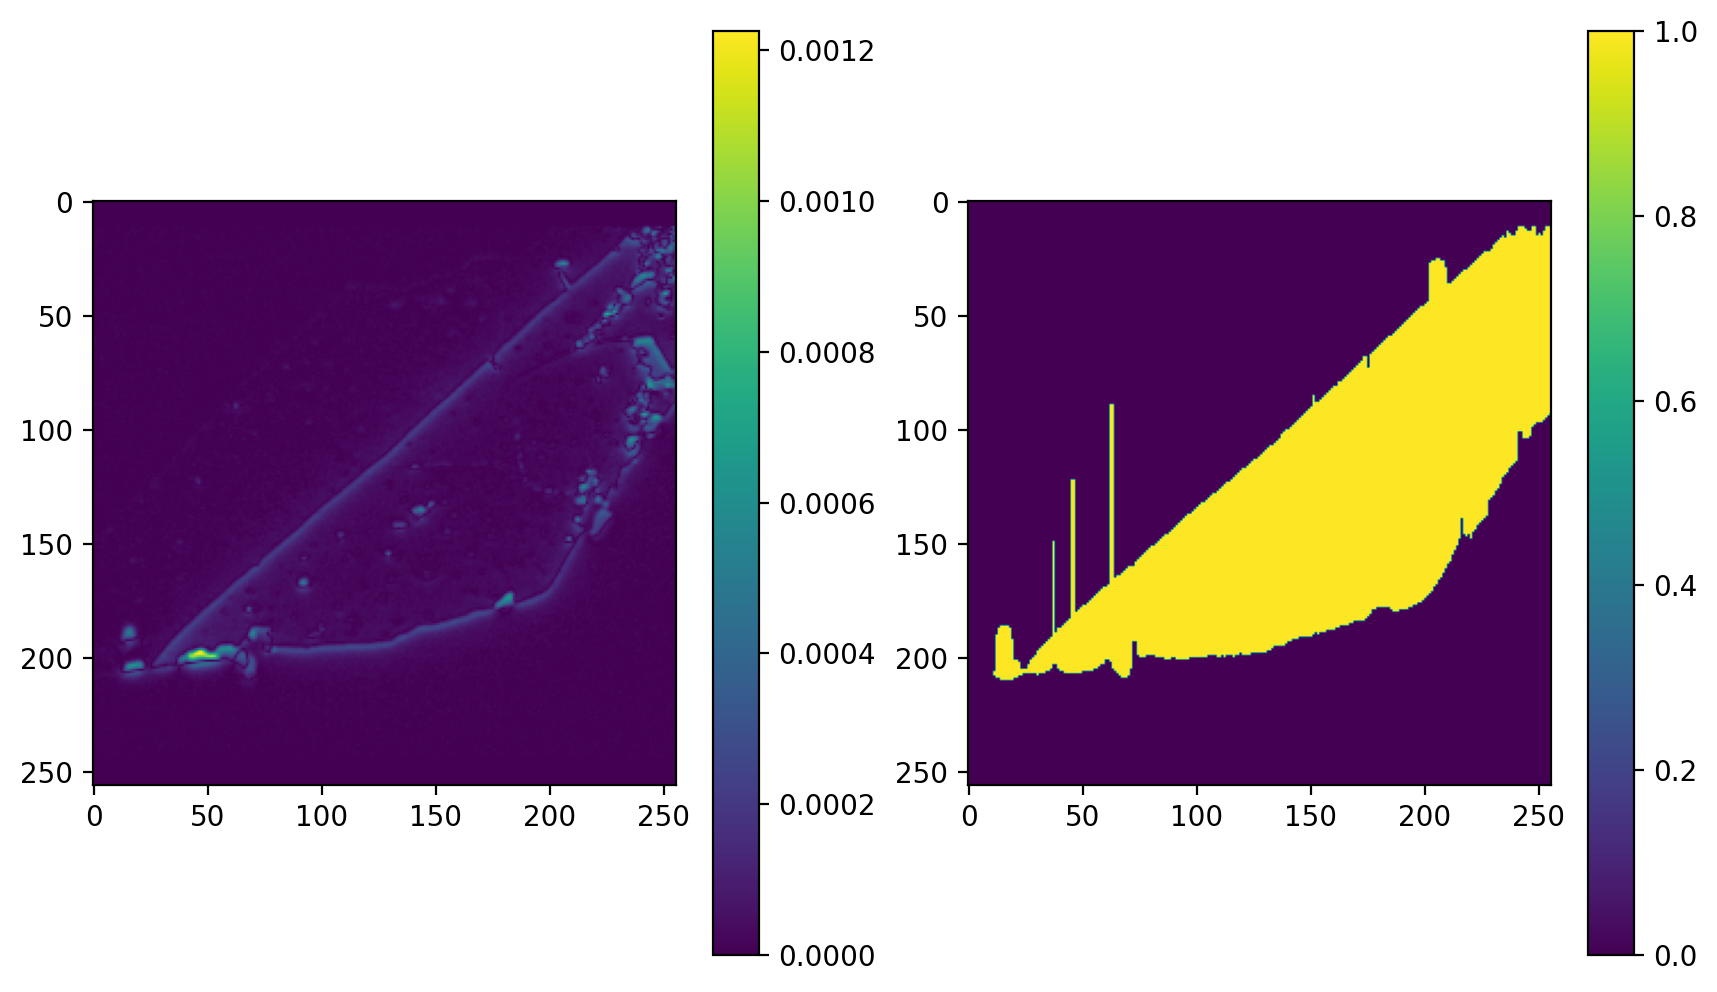

In [84]:
import scipy as sp
import magrec.image_processing.Masks as masks




threshold = 0.8e-4


source_weight = masks.mask_vert_dir(dataset.target, threshold, plot = True)

# fig = plt.figure()
# fig.set_figheight(6)
# fig.set_figwidth(16)

# plt.subplot(1,3,2)
# plt.imshow(dataset.target)
# plt.colorbar()

# plt.subplot(1,3,3)
# plt.imshow(wieght_mask, vmin = 0, vmax = 1)
# plt.colorbar()

# weight = torch.from_numpy(wieght_mask)

# source_weight = torch.ones(dataset.target.shape)
# source_weight = source_weight * weight


## Now we will try to reconstruct the magnetisation using a neural network.

Applied a high frequency filter, removing all components smaller than 0.035 um
Spatial filter implemented into the model with a width of 0.04 and 0.04 pixels or 0.00 um.
Number of sources: 1
Number of targets: 1
Including source angles in the neural network: False


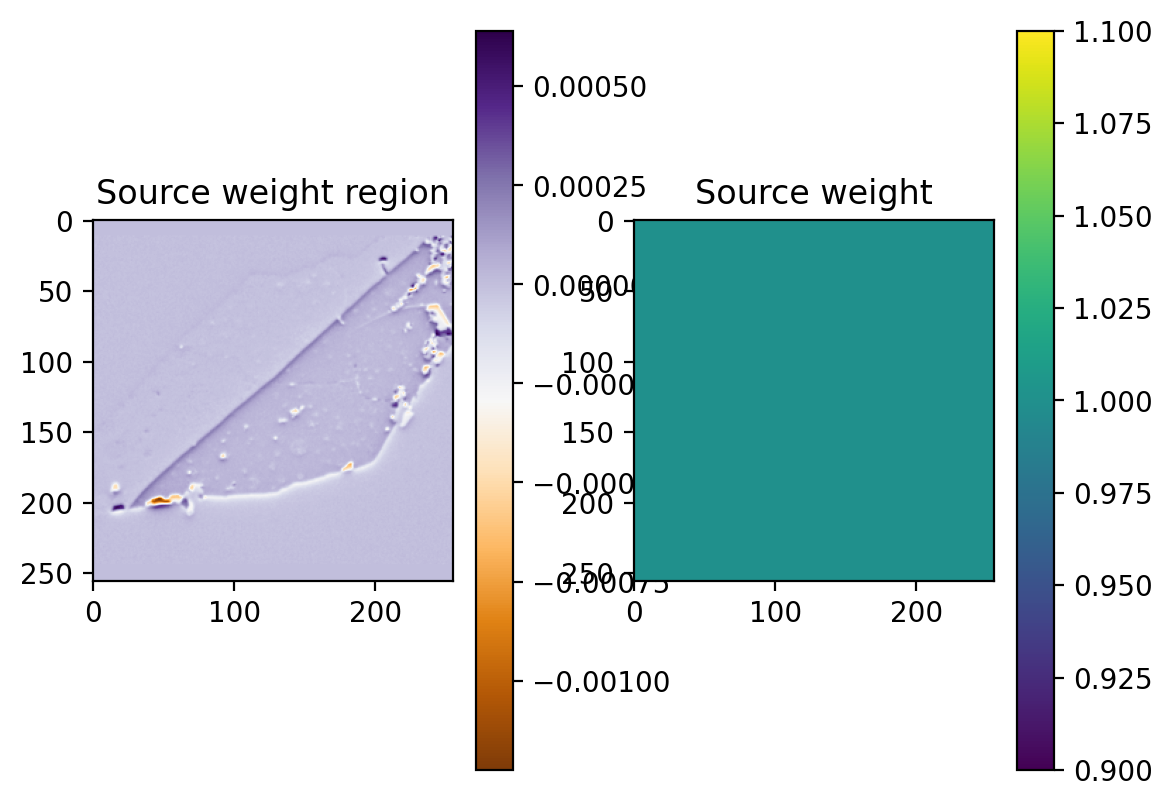

In [80]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

Model = UniformMagnetisation(dataset, 
                            loss_type = "MSE",  
                            scaling_factor = 1e9,
                            m_theta = 0, 
                            m_phi = 0,             
                            source_weight = source_weight,
                            loss_weight = None, 
                            spatial_filter = True, 
                            spatial_filter_type = "Hanning",
                            spatial_filter_width = [height, height])


Model.plot_weights()
FittingMethod = FCNN(Model)



In [81]:
FittingMethod.fit(n_epochs=1001)

epoch     1 | loss on last mini-batch:  4.18e+09


KeyboardInterrupt: 

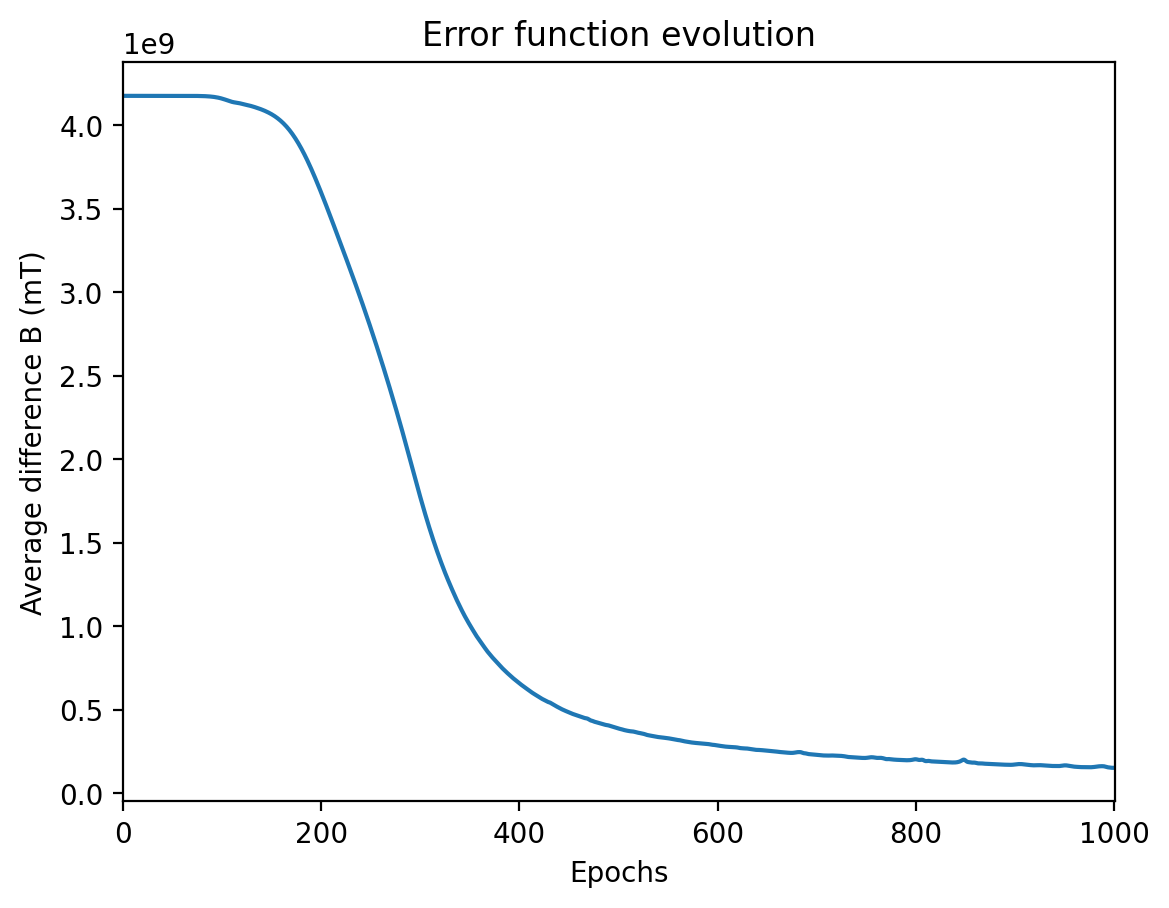

In [62]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


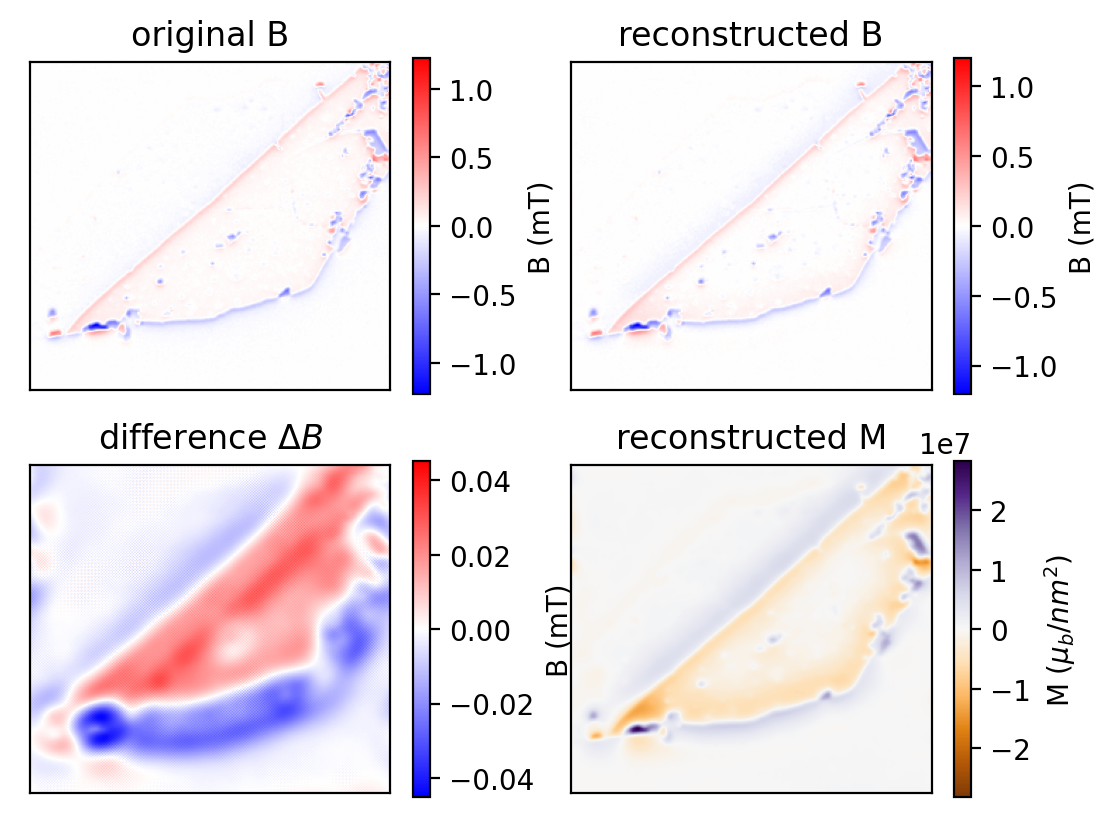

In [63]:
FittingMethod.plot_results()